### Sistem Rekomendasi Tempat Wisata Bali - Bertnardo Mario Uskono

Dataset: [Bali Tourist Attractions Dataset from Google Maps](https://www.kaggle.com/datasets/bertnardomariouskono/bali-tourist-attractions-dataset-from-google-maps)

**1. Import Library**

In [17]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel
import matplotlib.pyplot as plt
import seaborn as sns

Dokumentasi:

Pada tahap ini, kita mengimpor pustaka penting untuk pemrosesan data dan sistem rekomendasi.
* pandas: untuk manipulasi data berbentuk tabel.
* TfidfVectorizer: mengubah teks menjadi representasi numerik berbobot berdasarkan frekuensi kata.
* linear_kernel: untuk menghitung kesamaan cosine antar vektor TF-IDF.
* matplotlib & seaborn: untuk visualisasi data.

Mengimpor pustaka ini adalah langkah dasar agar kita bisa memuat, mengolah, dan memvisualisasikan data.

---

**2. Load Dataset**

In [7]:
df = pd.read_csv('/content/dataset_tempat_wisata_bali_cleaned.csv')
print(f"Jumlah data: {len(df)}")
df.head()

Jumlah data: 772


,nama,kategori,kabupaten_kota,rating,preferensi,link_lokasi,latitude,longitude,link_gambar
0,Taman Mumbul Sangeh,Alam,Kabupaten Badung,4.6,Wisata Alam,https://www.google.com/maps/place/Taman+Mumbul...,-8.483959,115.212288,https://lh3.googleusercontent.com/p/AF1QipPniB...
1,Sangeh Monkey Forest,Alam,Kabupaten Badung,4.6,Wisata Alam,https://www.google.com/maps/place/Sangeh+Monke...,-8.481774,115.206739,https://lh3.googleusercontent.com/p/AF1QipN2_T...
2,Objek Wisata Sangeh,Umum,Kabupaten Badung,4.6,Wisata Umum,https://www.google.com/maps/place/Objek+Wisata...,-8.481566,115.206546,https://lh3.googleusercontent.com/p/AF1QipO1t7...
3,Satria Gatotkaca Park,Umum,Kabupaten Badung,4.6,Wisata Umum,https://www.google.com/maps/place/Satria+Gatot...,-8.744388,115.178867,https://lh3.googleusercontent.com/p/AF1QipP3kd...
4,Desa Wisata Penarungan,Umum,Kabupaten Badung,5.0,Wisata Umum,https://www.google.com/maps/place/Desa+Wisata+...,-8.539637,115.198893,https://lh3.googleusercontent.com/p/AF1QipO-JZ...


Dokumentasi:
* Dataset berisi 772 baris data tempat wisata Bali.  
* Fungsi df.head() menampilkan 5 baris pertama untuk memberikan gambaran tentang struktur dan isi data.
* Kolom utama meliputi nama tempat wisata, kategori, kabupaten/kota, rating, preferensi, dan informasi lokasi.
* Output akan berupa tabel ringkas yang memperlihatkan data awal.

---

**3. Data Understanding: Distribusi Kategori**

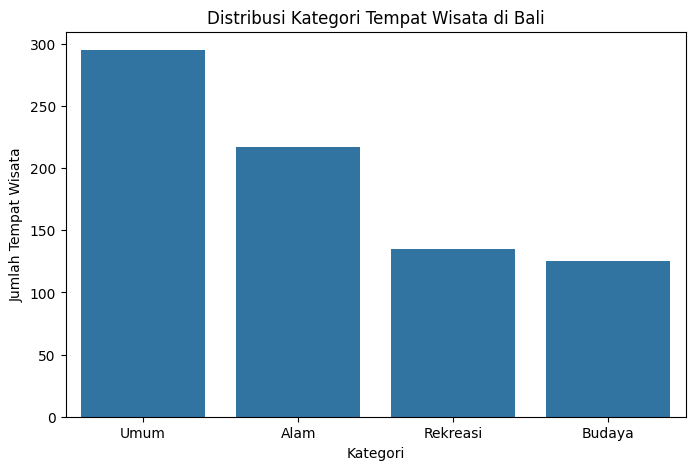

In [18]:
plt.figure(figsize=(8,5))
sns.countplot(data=df, x='kategori', order=df['kategori'].value_counts().index)
plt.title('Distribusi Kategori Tempat Wisata di Bali')
plt.xlabel('Kategori')
plt.ylabel('Jumlah Tempat Wisata')
plt.show()

Dokumentasi:
* Visualisasi ini menunjukkan jumlah tempat wisata untuk tiap kategori (Alam, Budaya, Rekreasi, Umum).
* Output berupa grafik batang yang memudahkan melihat kategori mana yang paling banyak dan paling sedikit.
* Informasi ini berguna untuk memahami proporsi data sebelum membuat model.

---

**4. Data Preparation**

In [9]:
df['features'] = df['kategori'] + ' ' + df['preferensi']

Dokumentasi:

* Membuat kolom baru **features** dengan menggabungkan kolom **kategori** dan **preferensi**.
* Ini bertujuan menyediakan fitur teks yang representatif untuk sistem rekomendasi content-based filtering.
* Output tidak menghasilkan tampilan, tapi data dataframe sekarang memiliki kolom baru yang berisi gabungan teks.

---

**5. TF-IDF Vectorization**

In [10]:
tfidf = TfidfVectorizer()
tfidf_matrix = tfidf.fit_transform(df['features'])
print(f"Dimensi matriks TF-IDF: {tfidf_matrix.shape}")

Dimensi matriks TF-IDF: (772, 5)


Dokumentasi:

* Mengubah kolom 'features' menjadi matriks TF-IDF, yang merepresentasikan setiap kata sebagai bobot penting.
* Matriks berdimensi (jumlah data x jumlah fitur unik).  
* Output berupa bentuk matriks, misal (772, 5) artinya 772 tempat wisata dengan 5 fitur kata unik.
* Matriks ini digunakan untuk mengukur kemiripan antar tempat wisata.

---

**6. Cosine Similarity**

In [11]:
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)

Dokumentasi:

* Menghitung skor cosine similarity antar setiap pasangan tempat wisata.
* Nilai similarity berkisar antara 0 sampai 1; semakin tinggi berarti semakin mirip.
* Output adalah matriks persegi 772x772 yang berisi skor kemiripan antar tempat.


**Visualisasi Heatmap Cosine Similarity (subset kecil)**

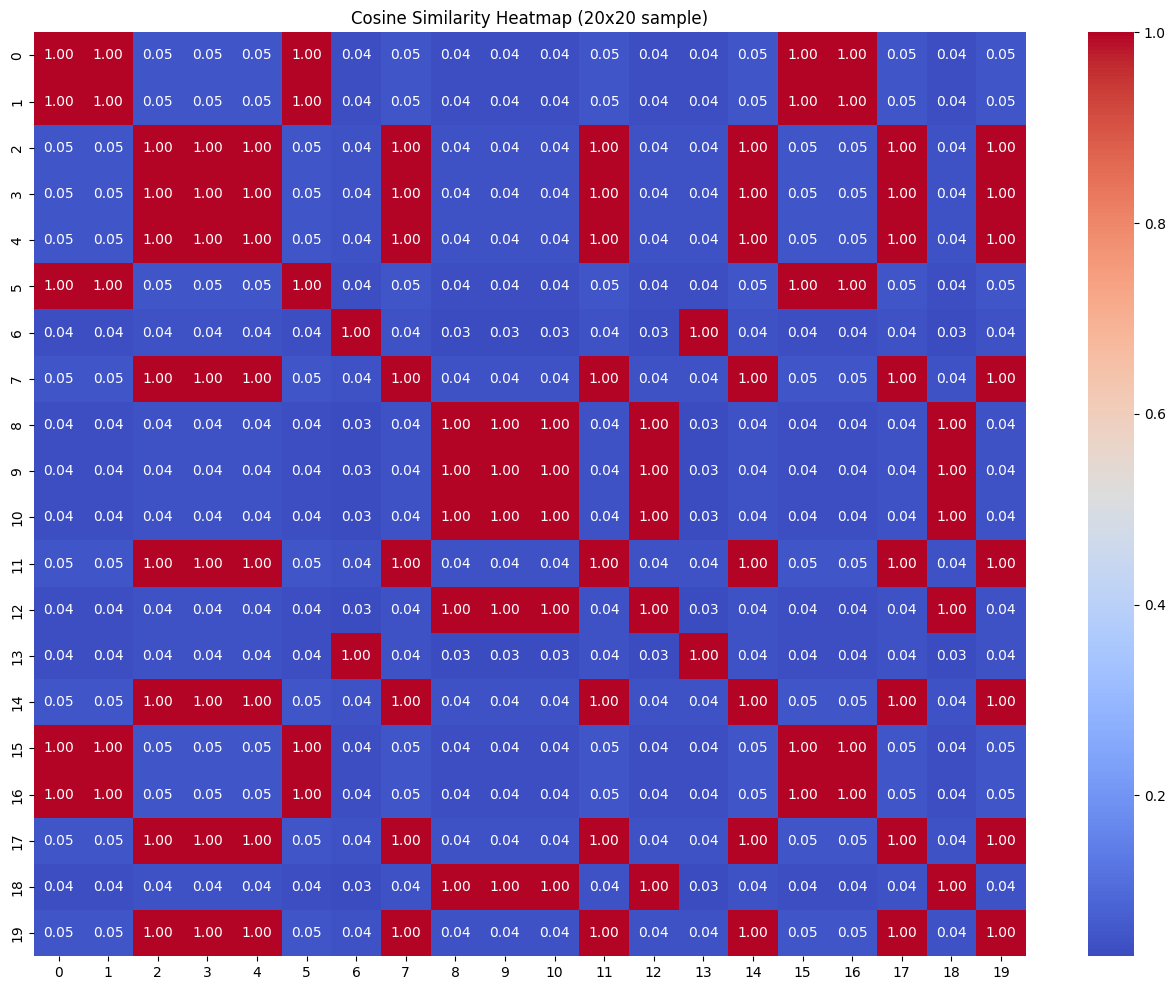

In [27]:
plt.figure(figsize=(16,12))
sns.heatmap(cosine_sim[:20, :20], cmap='coolwarm', annot=True, fmt=".2f")
plt.title('Cosine Similarity Heatmap (20x20 sample)')
plt.show()

**7. Mapping nama tempat ke indeks**

In [12]:
indices = pd.Series(df.index, index=df['nama']).drop_duplicates()

Dokumentasi:

* Membuat dictionary yang memetakan nama tempat wisata ke indeks dataframe.
* Mempermudah pencarian data saat melakukan rekomendasi berdasarkan nama.
* Output adalah objek pandas Series yang menghubungkan nama dengan indeks.

---

**8. Fungsi Rekomendasi**

In [13]:
def recommend_places(place_name, cosine_sim=cosine_sim):
    """
    Fungsi untuk merekomendasikan 10 tempat wisata yang mirip berdasarkan nama tempat.
    """
    if place_name not in indices:
        return f"Tempat '{place_name}' tidak ditemukan."

    idx = indices[place_name]
    sim_scores = list(enumerate(cosine_sim[idx].flatten()))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:11]
    place_indices = [i[0] for i in sim_scores]
    return df[['nama', 'kategori', 'rating']].iloc[place_indices]

Dokumentasi:

Fungsi ini menerima nama tempat wisata dan mengembalikan 10 tempat wisata lain yang paling mirip.\
Prosesnya:  
* Cari indeks tempat wisata dalam data  
* Ambil skor kemiripan dari matriks cosine similarity  
* Urutkan berdasarkan skor tertinggi (kecuali tempat yang dicari sendiri)  
* Ambil 10 teratas  

Output berupa dataframe dengan kolom nama, kategori, dan rating tempat wisata yang direkomendasikan.


**9. Contoh Penggunaan**

In [14]:
place = 'Taman Mumbul Sangeh'
print(f"Rekomendasi tempat wisata mirip dengan '{place}':")
recommendations = recommend_places(place)
print(recommendations)

Rekomendasi tempat wisata mirip dengan 'Taman Mumbul Sangeh':
                                       nama kategori  rating
1                      Sangeh Monkey Forest     Alam     4.6
5                                 Waterblow     Alam     4.4
15                 Taman Sari Wisata Bahari     Alam     4.2
16                     Monumen Taman Mumbul     Alam     4.0
21  Deluang Sari Turtle Conservation Center     Alam     4.0
27                   Obyek Wisata Goa Gajah     Alam     4.3
41                Daya Tarik Wisata Bedugul     Alam     4.7
47                Grubugan Waterfall Sading     Alam     4.0
52              Taman Rekreasi Delta Dalung     Alam     4.7
54                        Taman desa Dalung     Alam     5.0


**Visualisasi Rating Tempat yang Direkomendasikan**

<ipython-input-29-0f80d5b0350d>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='rating', y='nama', data=recommendations, palette='viridis')


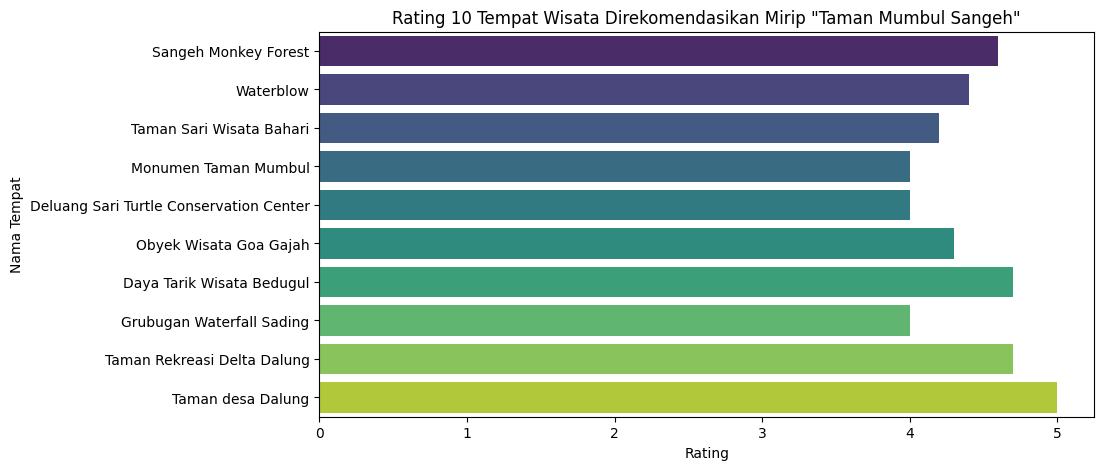

In [29]:
plt.figure(figsize=(10,5))
sns.barplot(x='rating', y='nama', data=recommendations, palette='viridis')
plt.title(f'Rating 10 Tempat Wisata Direkomendasikan Mirip "{place}"')
plt.xlabel('Rating')
plt.ylabel('Nama Tempat')
plt.show()

Dokumentasi:
* Menjalankan fungsi rekomendasi untuk tempat wisata 'Taman Mumbul Sangeh'.
* Output adalah tabel yang berisi 10 rekomendasi tempat wisata teratas yang mirip dengan input.
* Tabel menampilkan nama, kategori, dan rating sebagai informasi pendukung bagi pengguna.

---

**10. Evaluasi Sederhana**

In [15]:
print("Rating rata-rata dari tempat yang direkomendasikan:")
print(recommendations['rating'].mean())

Rating rata-rata dari tempat yang direkomendasikan:
4.390000000000001


Dokumentasi:
* Menghitung rata-rata rating tempat-tempat wisata yang direkomendasikan.
* Ini sebagai evaluasi awal untuk memastikan tempat yang direkomendasikan memiliki rating baik.
* Output berupa angka desimal yang merepresentasikan rata-rata rating.

---